<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Metadata" data-toc-modified-id="Cell-Metadata-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Metadata</a></span></li><li><span><a href="#PCs" data-toc-modified-id="PCs-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>PCs</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Clustering-evaluation" data-toc-modified-id="Clustering-evaluation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Clustering evaluation</a></span></li><li><span><a href="#Supervised-Prediction" data-toc-modified-id="Supervised-Prediction-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Supervised Prediction</a></span></li><li><span><a href="#Save" data-toc-modified-id="Save-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Save</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Consensus-Matrix" data-toc-modified-id="Consensus-Matrix-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Consensus Matrix</a></span></li><li><span><a href="#Clusters" data-toc-modified-id="Clusters-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Clusters</a></span></li></ul></li><li><span><a href="#Testing-Proba" data-toc-modified-id="Testing-Proba-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Testing Proba</a></span></li><li><span><a href="#Outlier-Proba" data-toc-modified-id="Outlier-Proba-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Outlier Proba</a></span></li><li><span><a href="#Compare-Proba" data-toc-modified-id="Compare-Proba-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Compare Proba</a></span></li></ul></div>

# Dimension Reduction and Manifold Learning

## Purpose
- Consensus clustering
- Outlier detection
- Supervised model training

## Input
- adata with PCs

## Output
- Clsuter assignment
- Outlier assignment
- Supervised model for prediction clusters on new data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.clustering import ConsensusClustering
from cemba_data.plot import *

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
result_dir = pathlib.Path('Cluster')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/consensus_clustering')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
cell_meta_path = './Coords/cell_tidy_data.msg'
adata_path = './Coords/adata.with_pc_and_coords.h5ad'

coord_base = 'umap'
n_jobs=40

# cc.fit_predict
n_neighbors=25
metric='euclidean'
neighbor_kwds=None
leiden_repeats=200
seed=1
leiden_resolution=0.5
leiden_kwds=None
min_cluster_size=10
min_cluster_portion=0.01
min_samples=1
epsilon='auto'
hdbscan_kwds=None

# cc.supervise_training
x=None
test_portion=0.1
n_estimators=500
n_splits=10
fbeta=1
average='weighted'
outlier_proba_cutoff=0.5
confusion_merge_cutoff=0.2

In [5]:
# Parameters
coord_base = "umap"
n_jobs = 40
n_neighbors = 25
metric = "euclidean"
neighbor_kwds = None
leiden_repeats = 200
seed = 1
leiden_resolution = 0.3
leiden_kwds = None
min_cluster_size = 10
min_cluster_portion = 0.01
min_samples = 1
epsilon = "auto"
hdbscan_kwds = None
x = None
test_portion = 0.1
n_estimators = 500
n_splits = 10
fbeta = 1
average = "weighted"
outlier_proba_cutoff = 0.3
confusion_merge_cutoff = 0.2


In [6]:
consensus_cluster_params = dict(n_neighbors=n_neighbors,
                                metric=metric,
                                neighbor_kwds=neighbor_kwds,
                                leiden_repeats=leiden_repeats,
                                seed=seed,
                                leiden_resolution=leiden_resolution,
                                leiden_kwds=leiden_kwds,
                                min_cluster_size=min_cluster_size,
                                min_cluster_portion=min_cluster_portion,
                                min_samples=min_samples,
                                epsilon=epsilon,
                                hdbscan_kwds=hdbscan_kwds,
                                n_jobs=n_jobs)
# cc.supervise_training(**training_params)
training_params = dict(x=x,
                       test_portion=test_portion,
                       n_estimators=n_estimators,
                       n_splits=n_splits,
                       fbeta=fbeta,
                       average=average,
                       n_jobs=n_jobs,
                       outlier_proba_cutoff=outlier_proba_cutoff,
                       confusion_merge_cutoff=confusion_merge_cutoff)

## Load

### Cell Metadata

In [7]:
cell_tidy_data = pd.read_msgpack(cell_meta_path)

### PCs

In [8]:
adata = anndata.read_h5ad(adata_path)
pc_matrix = adata.obsm['X_pca']

## Clustering

In [9]:
cc = ConsensusClustering(pc_matrix)

In [10]:
cc.fit_predict(**consensus_cluster_params)

Run compute_neighbors
Run multi_leiden_clustering
Repeating leiden clustering found 2 - 2 clusters, mean 2.0, std 0.00
Run hdbscan_clustering
Final consensus clustering found 2 clusters


## Clustering evaluation

In [11]:
reselect_epsilon = None

if reselect_epsilon is not None:
    cc.reselect_clusters(epsilon=reselect_epsilon, min_cluster_size=10)

[Text(0.5, 1.0, 'Before Rescue')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


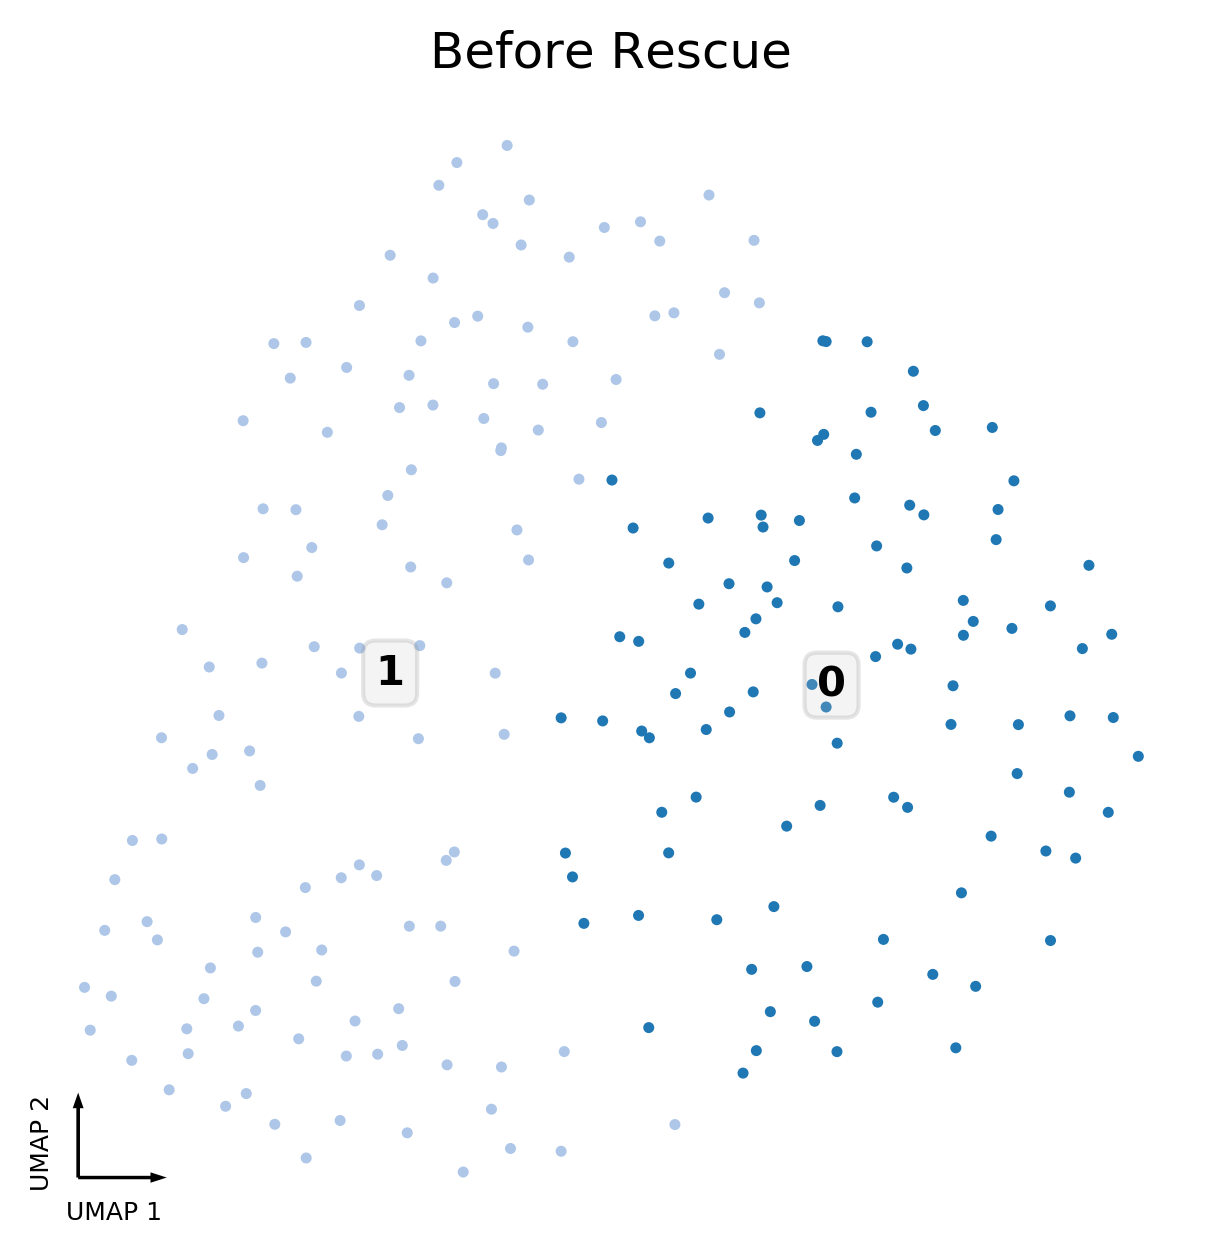

In [12]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(data=cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax,
                    hue=pd.Series(cc.consensus_clusters,
                                  index=adata.obs_names),
                    palette='tab20',
                    text_anno=pd.Series(cc.consensus_clusters,
                                        index=adata.obs_names))
ax.set(title='Before Rescue')

## Supervised Prediction

In [13]:
cc.supervise_training(**training_params)

2 input clusters
203 training obs
22 testing obs
0 outliers
Run RFECV
Final testing data
Overall balanced accuracy: 1.00


## Save

In [14]:
cc.save(result_dir / 'ConsensusCluster.Object.gz')

In [15]:
cell_tidy_data['consensus_cluster'] = pd.Series(
    cc.consensus_clusters,
    index=adata.obs_names)
cell_tidy_data['consensus_cluster_rescued'] = pd.Series(
    cc.consensus_clusters_rescued, 
    index=adata.obs_names)
cell_tidy_data.to_msgpack(result_dir / 'cell_tidy_data.with_cluster.msg')

## Plotting

### Consensus Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


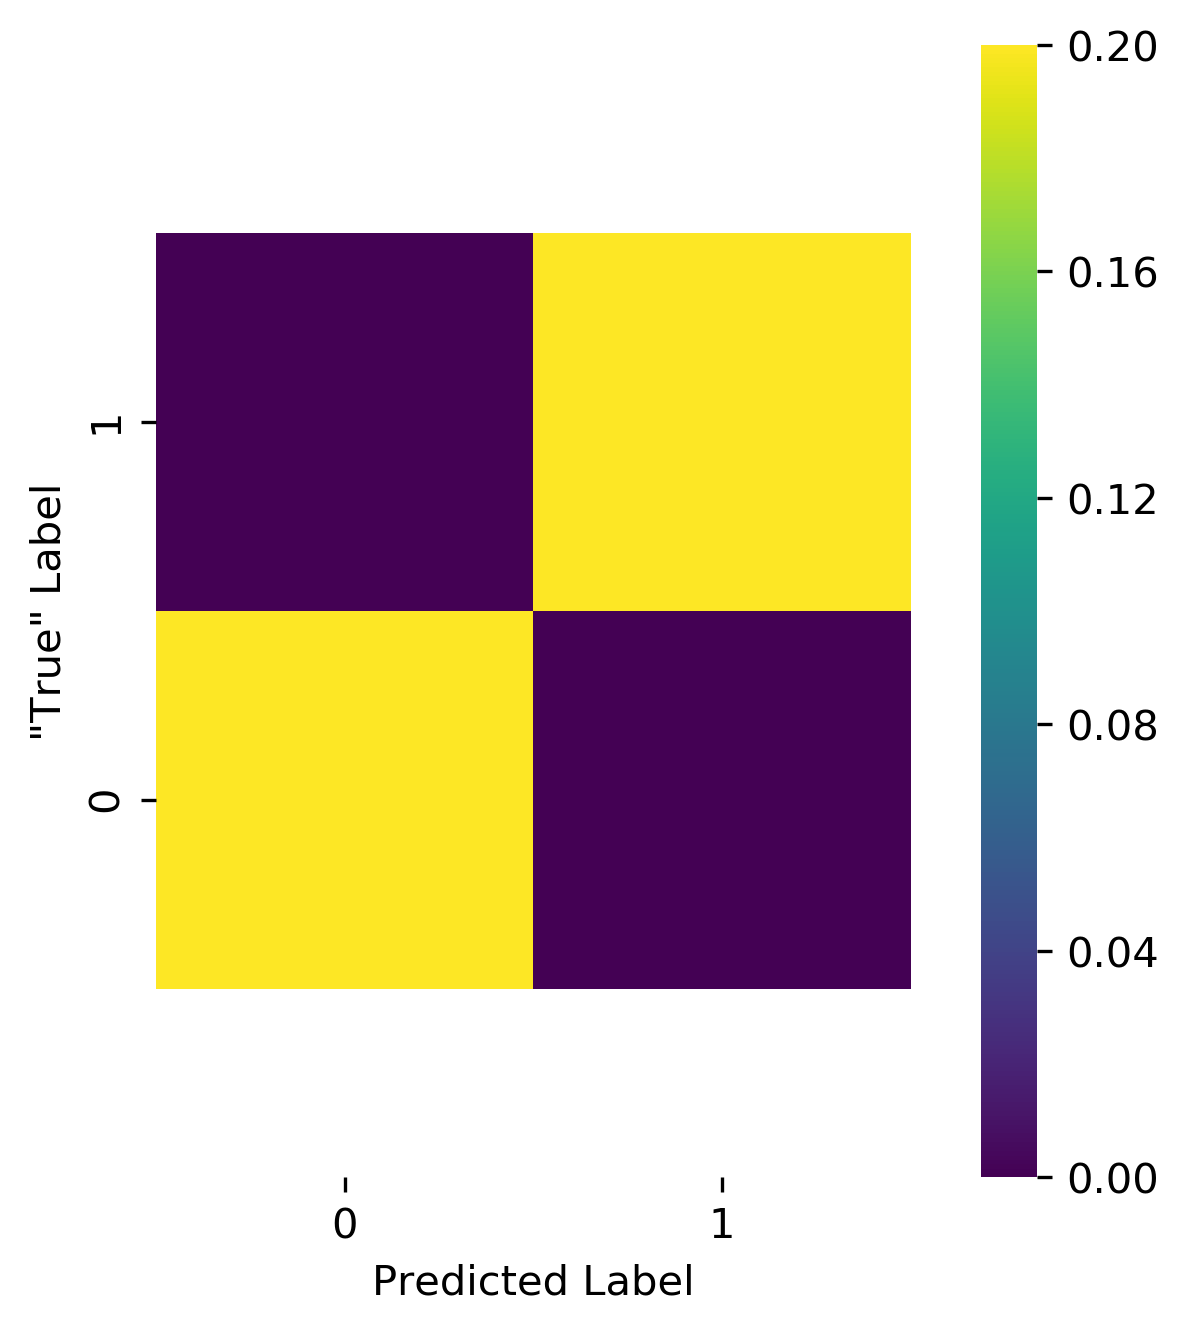

In [16]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
cc.plot_confusion_matrix(ax=ax)
fig.savefig(fig_dir / 'ConfusionMatrix.pdf')

### Clusters

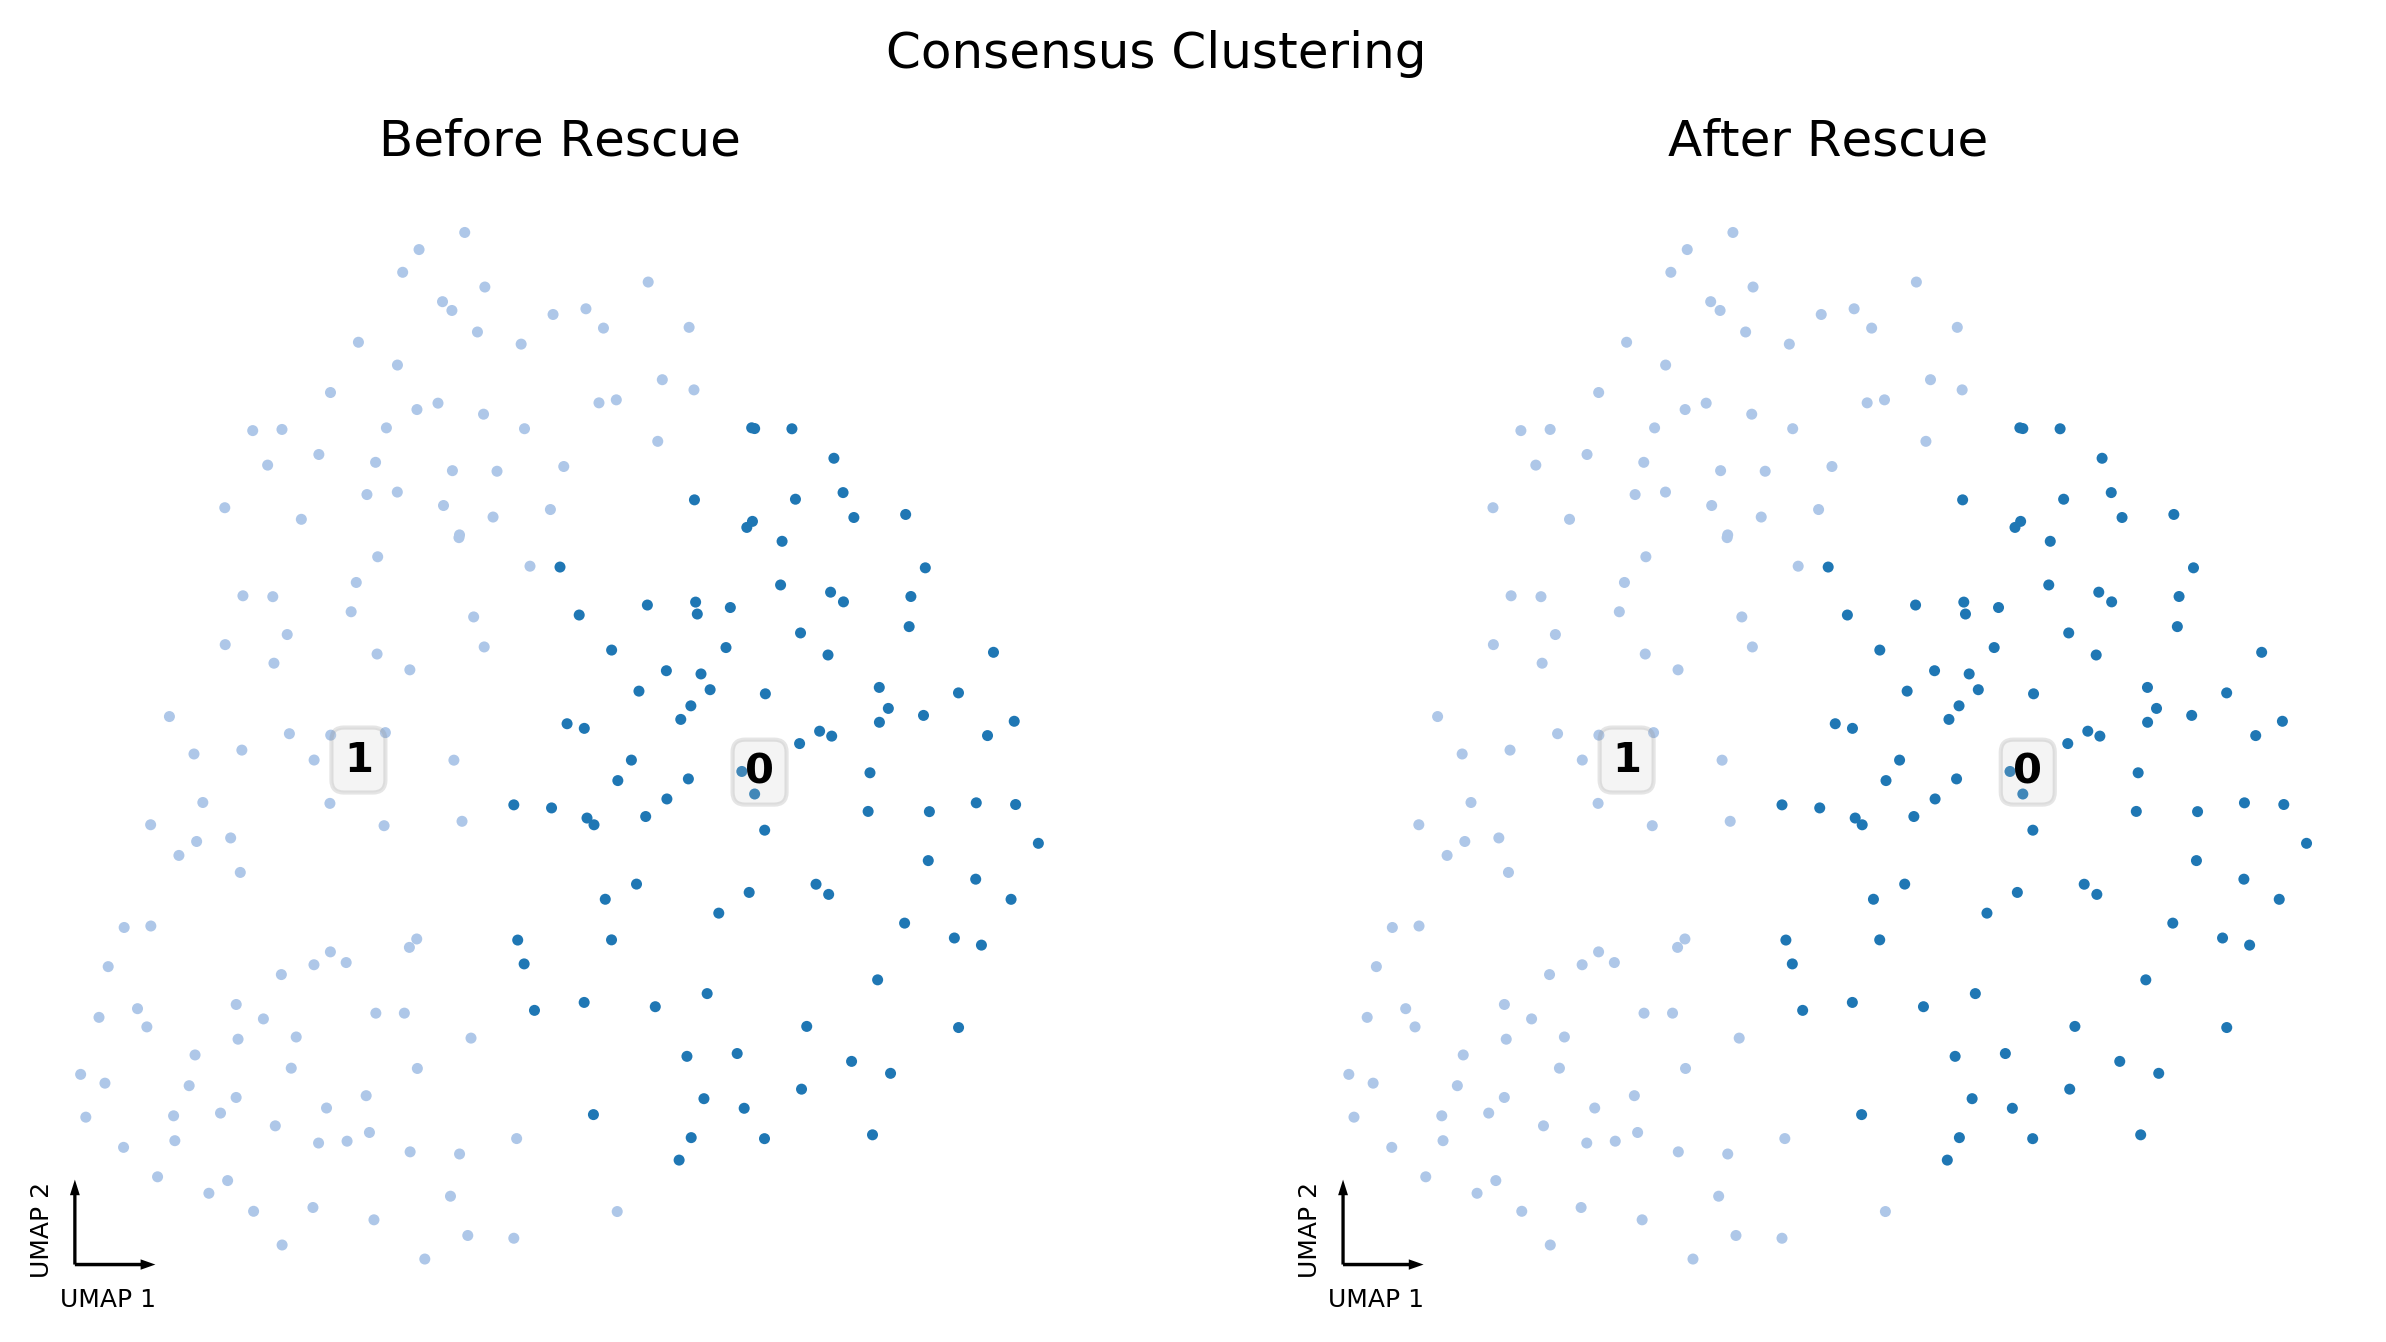

In [17]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(data=cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax1,
                    hue='consensus_cluster',
                    palette='tab20',
                    text_anno='consensus_cluster')
ax1.set(title='Before Rescue')

categorical_scatter(data=cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax2,
                    hue='consensus_cluster_rescued',
                    palette='tab20',
                    text_anno='consensus_cluster_rescued')
ax2.set(title='After Rescue')

fig.suptitle('Consensus Clustering')
fig.savefig(fig_dir / 'ConsensusClusters.pdf')

## Testing Proba

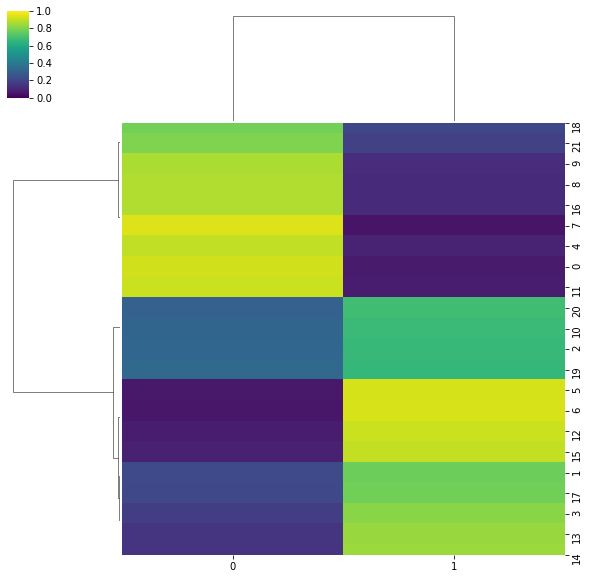

In [18]:
if cc.testing_proba is not None:
    g = sns.clustermap(cc.testing_proba,
                   metric='cosine',
                   vmin=0,
                   vmax=1,
                   cmap='viridis')
    g.fig.savefig(fig_dir / 'Testing.PredictionProbablity.pdf')

## Outlier Proba

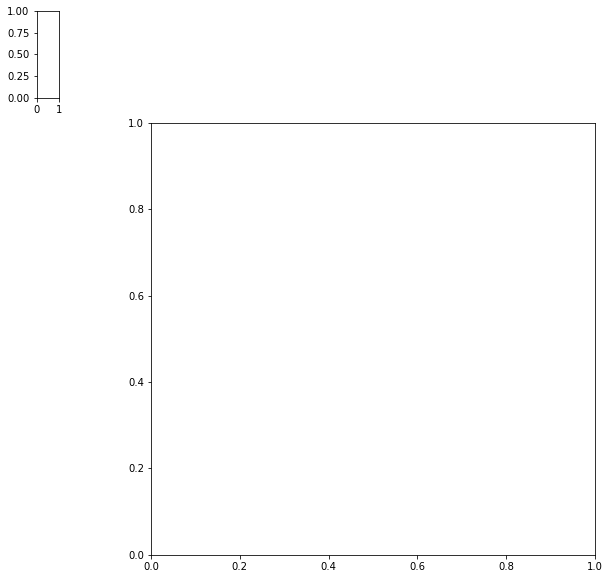

In [19]:
try:
    g = sns.clustermap(cc.outlier_proba, vmin=0, vmax=1, cmap='viridis')
    g.fig.savefig(fig_dir / 'Outlier.PredictionProbablity.pdf')
except ValueError:
    pass

## Compare Proba

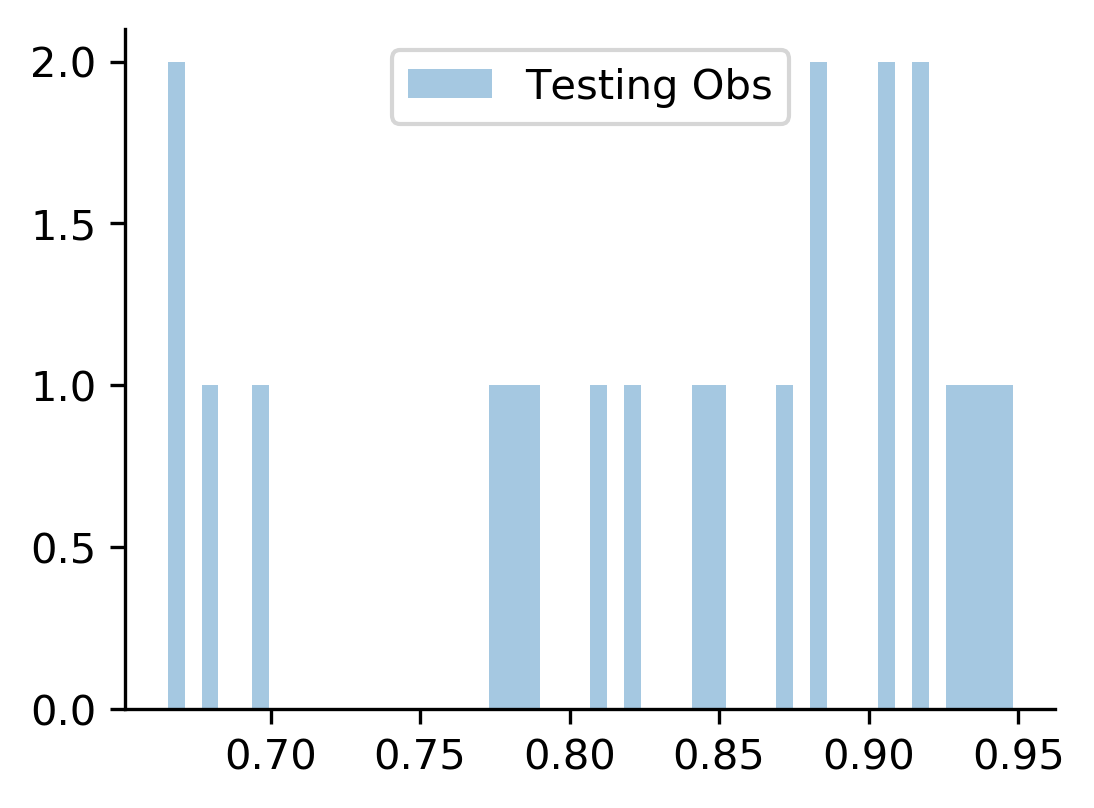

In [20]:
if cc.testing_proba is not None:
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

    cc.plot_prediction_probability(ax=ax)
    ax.legend()
    sns.despine(ax=ax)
    fig.savefig(fig_dir / 'TestingAndOutlier.MaxPredictionProbablity.pdf')